In [1]:
!pip install keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 4.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import keras_cv
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import losses
from tensorflow.keras import optimizers

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

In [4]:
data, dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
num_classes = dataset_info.features['label'].num_classes

In [6]:
train_steps_per_epoch = dataset_info.splits['train'].num_examples // BATCH_SIZE

In [7]:
# Prepare dataset for different augmentation methods

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {'images': image, 'labels': label}

def prepare_dataset(dataset):
    return dataset.shuffle(10 * BATCH_SIZE).map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

def load_dataset():
    dataset = data['train']
    return prepare_dataset(dataset)

In [8]:
train_dataset = load_dataset()

In [9]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
  for i, samples in enumerate(iter(dataset.take(9))):
      images = samples['images']
      plt.subplot(3, 3, i + 1)
      plt.imshow(images[0].numpy().astype('uint8'))
      plt.axis('off')
  plt.show()

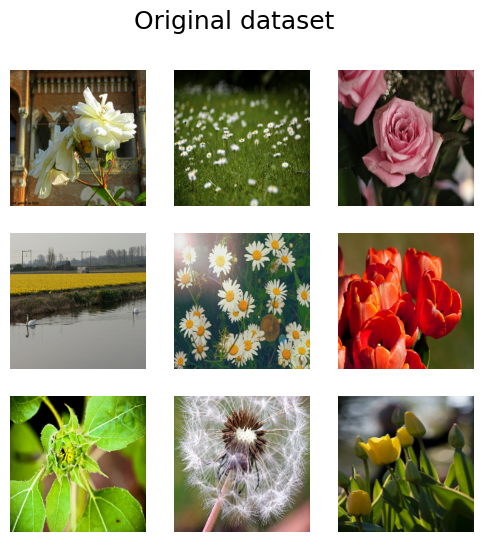

In [10]:
visualize_dataset(train_dataset, title='Original dataset')

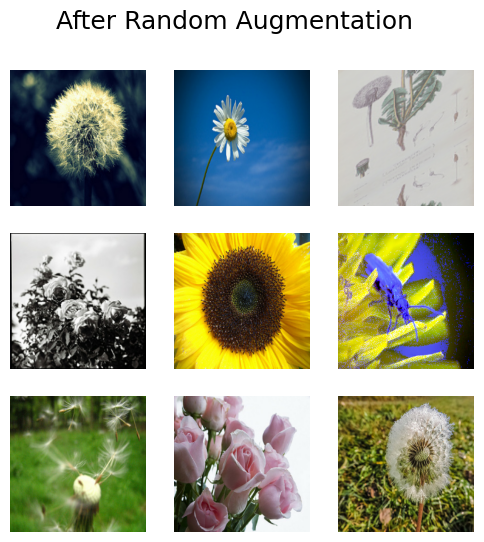

In [11]:
# Random augmentation

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=4,
    magnitude=0.5,
    magnitude_stddev=0.2,
    rate=0.5)

def apply_rand_augment(inputs):
    inputs['images'] = rand_augment(inputs['images'])
    return inputs

train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title='After Random Augmentation')

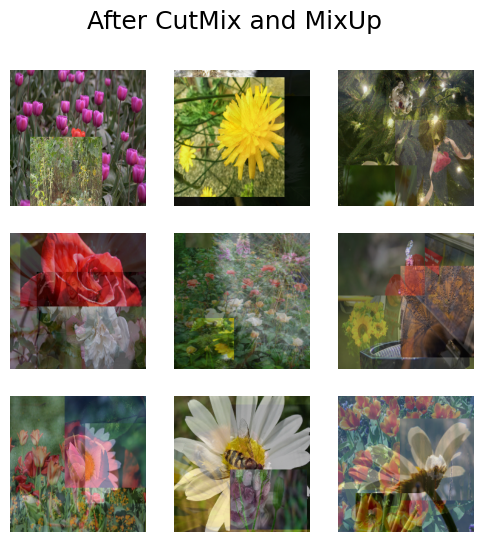

In [12]:
# Cutmix and mixup

cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()

def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples

train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title='After CutMix and MixUp')
     

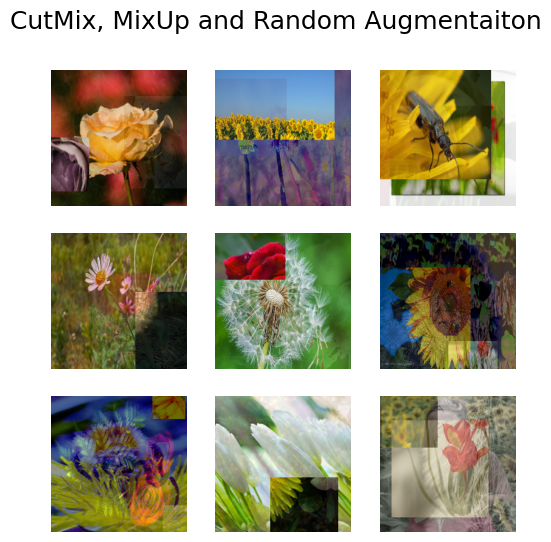

In [13]:
# Prepare training dataset for model training

def preprocess_for_model(inputs):
    images, labels = inputs['images'], inputs['labels']
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, 'CutMix, MixUp and Random Augmentaiton')

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

In [14]:
# Model for image classification

input_shape = IMAGE_SIZE + (3,)

def get_model():
    model = keras_cv.models.DenseNet121(
        include_rescaling=True, include_top=True, classes=num_classes)
    model.compile(
        loss=losses.CategoricalCrossentropy(),
        optimizer=optimizers.Adam(),
        metrics=['accuracy'],
    )
    return model

In [15]:
model = get_model()
model.fit(train_dataset, epochs=10)

Epoch 1/10
58/58 [==============================] - 164s 1s/step - loss: 1.5953 - accuracy: 0.3526
Epoch 2/10
58/58 [==============================] - 74s 1s/step - loss: 1.5141 - accuracy: 0.3777
Epoch 3/10
58/58 [==============================] - 74s 1s/step - loss: 1.4980 - accuracy: 0.3872
Epoch 4/10
58/58 [==============================] - 73s 1s/step - loss: 1.4896 - accuracy: 0.3940
Epoch 5/10
58/58 [==============================] - 73s 1s/step - loss: 1.4827 - accuracy: 0.4030
Epoch 6/10
58/58 [==============================] - 74s 1s/step - loss: 1.4767 - accuracy: 0.4196
Epoch 7/10
58/58 [==============================] - 73s 1s/step - loss: 1.4720 - accuracy: 0.4362
Epoch 8/10
58/58 [==============================] - 73s 1s/step - loss: 1.4760 - accuracy: 0.4150
Epoch 9/10
58/58 [==============================] - 72s 1s/step - loss: 1.4752 - accuracy: 0.4401
Epoch 10/10
58/58 [==============================] - 74s 1s/step - loss: 1.4511 - accuracy: 0.4420
